## MobileNet From Scratch

In [1]:
import pandas as pd
import numpy as np
import pathlib
from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
def get_train_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_train_for_keras = original_data.loc[original_data['is_valid'] == False, ['relative_path', 'label']]
    df_train_for_keras = df_train_for_keras.astype(str)
    return df_train_for_keras

def get_val_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_val_for_keras = original_data.loc[original_data['is_valid'] == True, ['relative_path', 'label']]
    df_val_for_keras = df_val_for_keras.astype(str)
    return df_val_for_keras

def get_test_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_test_for_keras = original_data[['relative_path', 'label']]
    df_test_for_keras = df_test_for_keras.astype(str)
    return df_test_for_keras

df_train_for_keras = get_train_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_train_for_keras[:5])

df_val_for_keras = get_val_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_val_for_keras[:5])

df_test_for_keras = get_test_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "test_group.csv")
print(df_test_for_keras[:5])

directory = str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage"

                                       relative_path label
0      Corn_(maize)___healthy/R.S_HL 7959 copy 2.jpg    10
1  Tomato___Spider_mites Two-spotted_spider_mite/...    33
2               Apple___Black_rot/JR_FrgE.S 8626.JPG     1
3                Tomato___healthy/GH_HL Leaf 207.JPG    37
4            Tomato___Leaf_Mold/Crnl_L.Mold 9008.JPG    31
                                           relative_path label
38070   Pepper,_bell___Bacterial_spot/JR_B.Spot 3293.JPG    18
38071        Squash___Powdery_mildew/UMD_Powd.M 0707.JPG    25
38072              Apple___Apple_scab/FREC_Scab 3120.JPG     0
38073               Grape___Black_rot/FAM_B.Rot 3107.JPG    11
38074  Tomato___Tomato_Yellow_Leaf_Curl_Virus/UF.GRC_...    35
                                       relative_path label
0  Tomato___Tomato_Yellow_Leaf_Curl_Virus/YLCV_NR...    35
1      Corn_(maize)___healthy/R.S_HL 7921 copy 2.jpg    10
2                Potato___Late_blight/RS_LB 3303.JPG    21
3            Tomato___Leaf_Mold/

In [4]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale=1./255,
                                   rotation_range=25,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_dataframe(df_train_for_keras,
                                                    directory=directory,
                                                    x_col='relative_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    drop_duplicates=False)
val_generator = val_datagen.flow_from_dataframe(df_val_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=64,
                                                shuffle=False,
                                                drop_duplicates=False)

Found 38070 validated image filenames belonging to 38 classes.
Found 5251 validated image filenames belonging to 38 classes.


In [6]:
from keras.layers import ZeroPadding2D,Conv2D,BatchNormalization,Input,Dropout,DepthwiseConv2D,Input
from keras.layers import ReLU,GlobalAveragePooling2D,GlobalMaxPool2D,Reshape,Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard

def MobileNet(
    input_shape=(224,224,3),
    width_multiplier = 1.0, #changes number of filters
    depth_multiplier = 1, # Resolution Multiplier
    include_top = True,
    weights = None,
    dropout = 1e-3,
    input_tensor = None,
    pooling = None, #Global Average/Max Pooling or None
    classes = 1000,
    ):

    #Input Shape
    if input_shape is None:
        default_size = 224
    else:
        rows,cols = input_shape[0],input_shape[1]
        #Make sure we use one of the mentioned sizes
        if rows==cols and rows in [128,160,192,224]:
            default_size = rows
        else:
            default_size = 224

    #Input Tensor
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor 

    #Standard Convolution
    #Block 0
    x = conv_block(img_input,32,width_multiplier,strides=(2,2))

    #Block 1
    x = depthwise_conv_block(x,64,width_multiplier,depth_multiplier,block_id=1)
    #Block2
    x = depthwise_conv_block(x,128,width_multiplier,depth_multiplier,strides=(2,2),block_id=2)
    #Block 3
    x = depthwise_conv_block(x,128,width_multiplier,depth_multiplier,block_id=3)
    #Block 4
    x = depthwise_conv_block(x,256,width_multiplier,depth_multiplier,strides=(2,2),block_id=4)
    #Block 5
    x = depthwise_conv_block(x,256,width_multiplier,depth_multiplier,block_id=5)
    #Block 6
    x = depthwise_conv_block(x,512,width_multiplier,depth_multiplier,strides=(2,2),block_id=6)
    #Block 7
    x = depthwise_conv_block(x,512,width_multiplier,depth_multiplier,block_id=7)
    #Block 8
    x = depthwise_conv_block(x,512,width_multiplier,depth_multiplier,block_id=8)
    #Block 9
    x = depthwise_conv_block(x,512,width_multiplier,depth_multiplier,block_id=9)
    #Block 10
    x = depthwise_conv_block(x,512,width_multiplier,depth_multiplier,block_id=10)
    #Block 11
    x = depthwise_conv_block(x,512,width_multiplier,depth_multiplier,block_id=11)
    #Block 12
    x = depthwise_conv_block(x,1024,width_multiplier,depth_multiplier,strides=(2,2),block_id=12)
    #Block 13
    x = depthwise_conv_block(x,1024,width_multiplier,depth_multiplier,block_id=13)

    if include_top:
        shape = (1,1,int(1024*width_multiplier))
        x = GlobalAveragePooling2D()(x)
        x = Reshape(shape,name='reshape_1')(x)
        x = Dropout(dropout,name='dropout')(x)
        x = Conv2D(classes,(1,1),padding='same',name='conv_fc')(x)
        x = Activation('softmax',name='softmax')(x)
        x = Reshape((classes,),name='reshape_2')(x)
    else:
        if pooling=='avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)

    #Create Model using functional API
    model = Model(inputs=img_input,outputs=x,name='mobilenet')

    if weights is not None:
        model.load_weights(weights)

    return model



def conv_block(inputs,filters,width_multiplier,kernel_size=(3,3),strides=(1,1)):
    #Inital Conv Layer with Batch Norm and Relu6
    #Input Shape : 4D Tensor (Samples,Rows,Cols,Channels)
    #Output Shape : 4D Tensor(Samples,New_Rows,New_Cols,Channels)
    #Width_Multiplier : Changes Number of Filters

    filters = int(filters*width_multiplier)

    #Params in Zero Padding ((top_pad, bottom_pad), (left_pad, right_pad))
    x = ZeroPadding2D(padding=((0,1),(0,1)),name='conv1_pad')(inputs)

    #Apply Standard Convolution without Bias and Batch Norm
    x = Conv2D(filters,kernel_size,padding='valid',use_bias=False,strides=strides,name='conv1')(x)
    x = BatchNormalization(name='conv1_bn')(x)


    # ReLu6 = min(max(features, 0), 6)
    x = ReLU(6.,name='conv1_relu')(x)
    return x


def depthwise_conv_block(inputs,pointwise_conv_filters,width_multiplier,depth_multiplier=1,strides=(1,1),block_id=1):

    """
    depth_multiplier: The number of depthwise convolution output channels
            for each input channel.
    The total number of depthwise convolution output
    channels will be equal to `filters_in * depth_multiplier`.
    """

    #Update the Number of Output Filters
    pointwise_conv_filters = int(pointwise_conv_filters*width_multiplier)

    if strides==(1,1):
        x = inputs
    else:
        x = ZeroPadding2D(padding=((0,1),(0,1)),name='conv_pad_%d'%block_id)(inputs)

    # Depth Wise Convolution
    x = DepthwiseConv2D((3,3),padding='same' if strides==(1,1) else 'valid',depth_multiplier=depth_multiplier,strides=strides,use_bias=False,name='conv_dw_%d'%block_id)(x)
    x = BatchNormalization(name='conv_dw_%d_bn'%block_id)(x)
    x = ReLU(6.,name='conv_dw_%d_relu'%block_id)(x)

    # PointWise Convolution with 1X1 Filters, No of Filters = pointwise_conv_filters	
    x = Conv2D(pointwise_conv_filters,(1,1),padding='same',use_bias=False,strides=(1,1),name='conv_pw_%d'%block_id)(x)
    x = BatchNormalization(name='conv_pw_%d_bn'%block_id)(x)
    x = ReLU(6.,name='conv_pw_%d_relu'%block_id)(x)

    return x

In [7]:
model = MobileNet(width_multiplier=1,depth_multiplier=1,classes=38)

model.compile(optimizer='adam',metrics=['accuracy'],loss='categorical_crossentropy')

model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
____________________

In [9]:
model.compile(loss="categorical_crossentropy", optimizer="adam",
           metrics=[metrics.categorical_accuracy])

history = model.fit_generator(train_generator,
                                  steps_per_epoch=849,
                                  epochs=20,
                                  validation_data=val_generator,
                                  validation_steps=170)  

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
849/849 [==============================] - 638s 751ms/step - loss: 0.9696 - categorical_accuracy: 0.7130 - val_loss: 3.0513 - val_categorical_accuracy: 0.4578
Epoch 2/20
849/849 [==============================] - 631s 743ms/step - loss: 0.3291 - categorical_accuracy: 0.8927 - val_loss: 1.7339 - val_categorical_accuracy: 0.6385
Epoch 3/20
849/849 [==============================] - 633s 745ms/step - loss: 0.1916 - categorical_accuracy: 0.9358 - val_loss: 1.3015 - val_categorical_accuracy: 0.6827
Epoch 4/20
849/849 [==============================] - 627s 738ms/step - loss: 0.1454 - categorical_accuracy: 0.9513 - val_loss: 2.5629 - val_categorical_accuracy: 0.5403
Epoch 5/20
849/849 [==============================] - 625s 736ms/step - loss: 0.1127 - categorical_accuracy: 0.9617 - val_loss: 2.4812 - val_categorical_accuracy: 0.5932
Epoch 6/20
849/849 [==============================] - 62

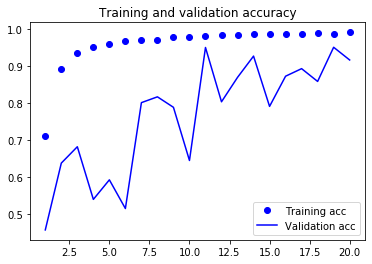

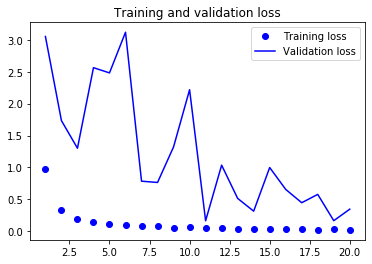

In [10]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.save(str(pathlib.Path.cwd()) + "/models/" + "resnet50_keras_stage_2_group.h5")